In [ ]:
# Google Colab에서 Kaggle API를 사용하기 위한 라이브러리 설치
!pip install kaggle

# Kaggle API 토큰 업로드
from google.colab import files
files.upload()

In [ ]:
# Kaggle API 토큰을 사용자 디렉토리로 복사하고 권한 설정
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Kaggle에서 데이터셋 다운로드
!kaggle datasets download -d kaggleprollc/healthcare-patient-satisfaction-data-collection

healthcare-patient-satisfaction-data-collection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# 다운로드한 데이터셋 압축 해제
!unzip healthcare-patient-satisfaction-data-collection.zip

Archive:  healthcare-patient-satisfaction-data-collection.zip
replace patient_satisfaction/cms_hospital_patient_satisfaction_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# 필요한 라이브러리 및 패키지 불러오기
!pip install transformers torch

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터셋 불러오기
df = pd.read_csv('patient_satisfaction/cms_hospital_patient_satisfaction_2020.csv', low_memory=False)

In [ ]:
# 긴 텍스트 필터링
max_text_length = 512
filtered_df = df[df['HCAHPS Answer Description'].apply(len) <= max_text_length]

# 필터링된 데이터셋에서 임의로 500개 선택
random_sample = filtered_df['HCAHPS Answer Description'].sample(n=500, random_state=42)
texts = random_sample.tolist()

In [ ]:
# 감정 클래스 분류
def classify_sentiment(sentiment):
    sentiment = sentiment.lower()

    if any(keyword in sentiment for keyword in ["always", "usually", "yes", "high", "strongly agree", "agree"]):
        return 1  # Positive
    elif any(keyword in sentiment for keyword in ["sometimes", "never", "no", "low", "strongly disagree", "disagree"]):
        return 0  # Negative
    else:
        return -1  # Undefined

In [ ]:
# 감정 분류를 적용하고 Undefined 값 제외
labeled_data = [(text, classify_sentiment(text)) for text in texts]
filtered_data = [(text, label) for text, label in labeled_data if label != -1]

# 필터링된 데이터를 풀어서 사용
filtered_texts, filtered_labels = zip(*filtered_data)

In [ ]:
# 데이터를 훈련 및 테스트 세트로 분할
texts_train, texts_test, labels_train, labels_test = train_test_split(filtered_texts, filtered_labels, test_size=0.2, random_state=42)

In [ ]:
# 토크나이저 및 모델 로드
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 훈련 및 테스트 세트에 대한 텍스트 데이터 토큰화
tokenized_texts_train = tokenizer(texts_train, padding=True, truncation=True, return_tensors="pt")
tokenized_texts_test = tokenizer(texts_test, padding=True, truncation=True, return_tensors="pt")

In [ ]:
# 트랜스포머 모델을 사용하여 훈련 세트에 대한 감성 분석 수행
outputs_train = model(**tokenized_texts_train, labels=torch.tensor(labels_train).unsqueeze(0))
outputs_test = model(**tokenized_texts_test, labels=torch.tensor(labels_test).unsqueeze(0))

In [ ]:
# 훈련 및 테스트 세트에 대한 감성 레이블 예측
predicted_train = torch.argmax(outputs_train.logits, dim=1).tolist()
predicted_test = torch.argmax(outputs_test.logits, dim=1).tolist()

In [ ]:
# 평가 메트릭
accuracy = accuracy_score(labels_test, predicted_test)
precision = precision_score(labels_test, predicted_test, average='weighted')
recall = recall_score(labels_test, predicted_test, average='weighted')
f1 = f1_score(labels_test, predicted_test, average='weighted')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# 평가 메트릭 출력
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.6711
Precision: 0.4503
Recall: 0.6711
F1 Score: 0.5390


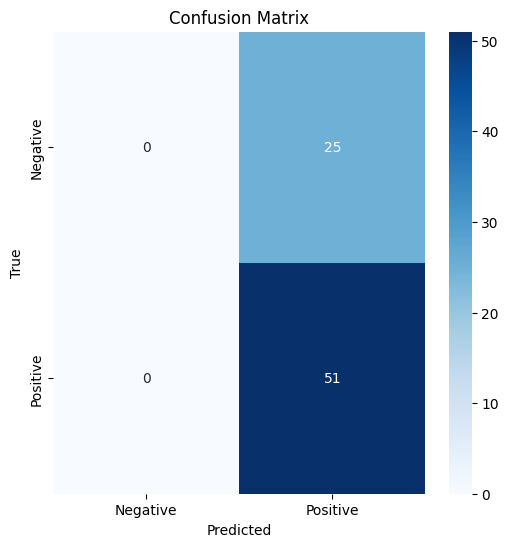

In [ ]:
# 혼동 행렬
cm = confusion_matrix(labels_test, predicted_test)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 0 25]
 [ 0 51]]
